### **Класифікація ґрунтів за допомогою глибокого навчання (Deep Learning)**

Класифікація ґрунтів може бути важливою задачею для різних галузей, включаючи геотехнічну інженерію, сільськогосподарську науку та будівництво. Хоча існує багато схем класифікації, популярний та інтуїтивно зрозумілий спосіб класифікації ґрунтів базується на розмірі зерен ґрунту, таких як гравій, мул, пісок тощо. Це досить простий спосіб класифікації ґрунтів, оскільки між кожною класифікацією існують чіткі межі. Наприклад, гравій - це будь-яке зерно діаметром понад 2 мм, пісок - від $\frac{1}{16}$ мм до 2 мм, а мул/глина - менше $\frac{1}{16}$  мм.

© [Джерело](https://apmonitor.com/pds/index.php/Main/SoilClassification)

### **Мета**
У цьому завданні комп'ютерний зір створює модель класифікації ґрунтів на основі фотографій гравію, піску та мулу. Для класифікації фотографій ґрунтів використовується згорткова (конволюційна) нейронна мережа (CNN).

### **Ключові поняття**:
___Аугментація (розширення) даних___ — це практика, яка часто використовується в класифікації зображень і полягає в збільшенні існуючого набору даних зображень шляхом створення нових наборів даних на основі існуючих. Таке розширення найчастіше застосовується в таких операціях, як зміщення зображення, дзеркальне відображення зображення по горизонталі або вертикалі, збільшення зображення тощо. Ці розширення створюють нові зображення і, таким чином, збільшують кількість зображень для навчання. Детальніше про це читайте в [статті Джейсона Браунлі](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/).

___Згорткова нейронна мережа (CNN)___ — популярна модель для класифікації зображень. CNN розрізняють характеристики зображення, проходячи по циклу через значення пікселів у зображенні та обчислюючи скалярний добуток цих пікселів з матрицею фільтра «ядра». Ці матриці ядра підкреслюють різні аспекти зображення, такі як вертикальні та горизонтальні лінії, кривизна тощо. Для отримання додаткової інформації про CNN див. [APMonitor — комп'ютерний зір із глибоким навчанням](https://apmonitor.com/pds/index.php/Main/VisionDeepLearning).

In [3]:
training_data_directory = 'train'
test_data_directory = 'test'

### **Налаштування**

Імпортуйте наступні модулі Python. Не забудьте використовувати pip для встановлення будь-яких пакетів, яких вам бракує. Наприклад, якщо ви отримуєте помилку: ``` ModuleNotFoundError: No module named 'cv2' ```, додайте нову клітинку, натиснувши кнопку "+" вище, та виконайте таку команду в іншій клітинці: !pip install opencv-python.

In [4]:
import os # Доступ до операцій файлової системи: створення, переміщення, видалення файлів і папок
import re # Регулярні вирази — для пошуку, заміни або перевірки шаблонів у тексті
#!pip install opencv-python
import cv2 # Бібліотека OpenCV — інструмент для комп’ютерного зору: обробка зображень, відео, фільтрація, розпізнавання об'єктів
import time # Вимірювання часу, затримки, таймери — корисно для логування або контролю продуктивності
import shutil # Копіювання та переміщення файлів і директорій
import zipfile # Робота з ZIP-архівами: розпаковування, створення, перегляд вмісту
import urllib.request # Завантаження файлів з інтернету (наприклад, моделей або датасетів)
import numpy as np
from PIL import Image # Pillow — бібліотека для роботи з зображеннями: відкриття, зміна розміру, збереження, конвертація форматів
from os import listdir
from os.path import isfile, join
from random import randrange # Генерація випадкових чисел у заданому діапазоні — наприклад, для випадкового вибору зображень
import matplotlib.pyplot as plt # Побудова графіків, гістограм, зображень — корисно для аналізу результатів моделі
#!pip install tensorflow
from tensorflow.keras.models import load_model # Завантаження збереженої моделі Keras (наприклад, .h5 файл)
from tensorflow.keras.preprocessing import image # Завантаження та перетворення зображень у формат, придатний для моделі Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Генерація зображень з аугментацією (зміна масштабу, обертання, дзеркалення) — покращує навчання моделі
from tensorflow.keras.models import Sequential # Створення послідовної моделі — найпростіший тип моделі в Keras
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

### **Дані**

Дані розділені на каталоги test та train. Папки test та train містять підкаталоги, що відповідають можливим ґрунтам. Позначена деревоподібна структура папок допомагає позначати фотографії для навчання та тестування.

In [5]:
# Завантажити soil_photos.zip за посиланням
file = 'soil_photos.zip'
url = 'http://apmonitor.com/pds/uploads/Main/'+file
urllib.request.urlretrieve(url, file)

# Розпакувати архів та видалити soil_photos.zip
with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall('./')
os.remove(file)

**Імпортуйте дані в сеанс Python**. \
Перший крок – обробити зображення у формат, який
1. Робить дані читабельними для моделі
2. Надає більше навчального матеріалу для моделі.

Так, змінна `training_data_processor` масштабує дані так, щоб вони могли бути вхідними даними моделі, але також бере кожне зображення та доповнює його, щоб модель могла навчатися на кількох варіаціях одного й того ж зображення. Вона перевертає його горизонтально, обертає, зміщує тощо, щоб модель навчалася на фотографії ґрунту, а не на орієнтації чи розмірі.

Навіщо? Щоб наша модель стала розумнішою і не "зазубрювала" картинки, а вчилася розпізнавати об'єкти в різних умовах.

Отже, `training_data_processor` — це наш "креативний" процесор для навчальних (train) матеріалів. Він бере кожне тренувальне зображення і під час тренування щоразу показує моделі його трохи змінену версію, що підвищує її стійкість до нових даних.

При цьому `ImageDataGenerator` — це клас, який допомагає автоматично змінювати (аугментувати) зображення під час тренування моделі.

**Що робить кожен параметр:**

* `rescale = 1./255`: Це найважливіший крок. Кожен піксель у кольоровому зображенні має яскравість від 0 (чорний) до 255 (дуже яскравий). Ця команда ділить значення кожного пікселя на 255. В результаті всі значення стають в діапазоні від 0 до 1. Моделям набагато легше працювати з такими маленькими числами.
* `horizontal_flip`: Випадково віддзеркалює зображення по горизонталі.
* `zoom_range`: Випадково наближує або віддаляє зображення на певний відсоток (%).
* `rotation_range`: Випадково повертає зображення на кут до заданої кількості градусів.
* `shear_range`: Це "зсув". Уявіть, що ви зсуваєте верхню частину прямокутника, перетворюючи його на паралелограм. Це імітує погляд на об'єкт під кутом.
* `height_shift_range` та `width_shift_range`: Трохи зсуває зображення вгору-вниз або вліво-вправо до заданого відсотку.


```test_data_processor``` — це наш "суворий екзаменатор".

Для тестових даних ми НЕ використовуємо аугментацію. Тест — це перевірка того, наскільки добре модель впорається з реальними, незміненими даними. Ми не хочемо давати їй підказки чи спотворювати "екзаменаційні завдання".

Єдине, що ми робимо, — це `rescale = 1./255`. Чому? Бо модель тренувалася на даних, де пікселі були в діапазоні 0-1. Щоб перевірка була справедливою, тестові дані мають бути в тому ж форматі.

In [6]:
# Запустити інструменти обробки даних
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,         # випадкове збільшення або зменшення масштабу зображення до 20%
    rotation_range = 10,      # випадкове обертання зображення на кут до 10 градусів
    shear_range = 0.2,        # випадкове зсування (зріз) зображення.
    height_shift_range = 0.1, # випадкове вертикальне зміщення до 10% висоти
    width_shift_range = 0.1   # випадкове горизонтальне зміщення до 10% ширини
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

**Завантаження зображень із папок**

Змінна `training_data` бере наш креативний процесор (`training_data_processor`) і застосовує його до зображень з папки `training_data_directory`.

* `flow_from_directory` — завантажує зображення з папки, автоматично розподіляючи їх по класах (підпапках).
* `training_data_directory` — шлях до папки з тренувальними зображеннями.
* `target_size = (256, 256)` — всі зображення змінюються до розміру 256x256 пікселів. Нейронні мережі вимагають, щоб усі вхідні зображення були однакового розміру.
* `batch_size = 32` — зображення завантажуються порціями по 32 штуки (це зручно для тренування).
* `class_mode = 'categorical'` — підходить для задач, де є кілька класів. Автоматично визнача' класи за назвами підпапок (Gravel, Sand, Silt) і перетворювати їх у формат, зрозумілий для моделі (наприклад, [1, 0, 0] для Gravel і [0, 1, 0] для Sand).

Аналогічно для завантаження тестових даних `testing_data`:
* `test_data_directory`: Шлях до папки test/.
* `shuffle = False`: Дуже важливо! Ця команда каже не перемішувати тестові дані. Під час тестування нам часто потрібно знати точні прогнози для кожного конкретного зображення, тому їх порядок має бути сталим. Для тренувальних даних перемішування увімкнене за замовчуванням, що є доброю практикою.

In [7]:
# Завантажити зображень в Python з папок
training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 75 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


Отже,
* тренувальні дані автоматично змінюються (аугментуються) для кращого навчання моделі
* тестові дані використовуються без змін, лише нормалізуються
* зображення беруться з папок, змінюються до потрібного розміру, групуються по класах і подаються в модель порціями.

### **Розробка моделі**

Наступний крок – побудова моделі **згорткової нейронної мережі** (CNN). У наступній ячейці встановлюються параметри для побудови моделі. Це включає кількість згорткових шарів, повністю зв'язаних щільних шарів, кількість вузлів у кожному шарі та кількість епох навчання. Для отримання додаткової інформації про ці параметри та згорткові нейронні мережі загалом див. [APMonitor - Комп'ютерний зір з глибоким навчанням](https://apmonitor.com/pds/index.php/Main/VisionDeepLearning).

* Параметр `layer_size` (розмір шару) має великий вплив на швидкість навчання, точність та розмір моделі. Це – "потужність" або "ширина" наших шарів. Кожен шар матиме певну кількість нейронів (або фільтрів).
* `num_conv_layers` (кількість згорткових шарів) - це "очі" нашої моделі, які шукають візерунки на зображенні.
* `num_dense_layers` (кількість повнозв’язних шарів) - це "мозок" моделі, який аналізує знайдені візерунки і приймає рішення.
* `num_training_epochs` (кількість епох навчання) – відповідає, скільки разів модель повинна "переглянути" всі навчальні зображення. Саме один такий перегляд називається ___епохою___.

In [8]:
# Задати параметри моделі
num_conv_layers = 2       # Кількість згорткових шарів
num_dense_layers = 1      # Кількість повнозв’язних шарів
layer_size = 32           # Розмір шару: 32 нейрони
num_training_epochs = 20  # Кількість епох навчання
MODEL_NAME = 'soil'       # Назва файлу, в який ми збережемо нашу навчену модель

Далі ми починаємо "будувати" нашу модель шар за шаром, як поверхи в будинку.

**Блок згорткових шарів (аналіз зображення)**

1. `Sequential()` створює порожній "каркас" для моделі, в який ми будемо послідовно додавати шари.
2. `Conv2D(layer_size, (3, 3), input_shape=(256,256, 3))` – це перший згортковий шар:
  * `Conv2D`: Головний інструмент, який сканує зображення маленьким "віконцем" (фільтром) розміром 3x3 пікселі, щоб знайти прості ознаки (лінії, кути, градієнти).
  * `layer_size` (32): Ми створюємо 32 таких фільтри, кожен з яких шукає свій унікальний візерунок.
  * `input_shape=(256,256, 3)`: Дуже важливо! Тільки для першого шару ми вказуємо, якого розміру зображення будуть надходити на вхід (256x256 пікселів, 3 канали для кольорів R, G, B).
3. `Activation('relu')`: Це "активатор". Він вирішує, чи є знайдений візерунок достатньо важливим, щоб передати його далі. ___relu___ — це просте правило: якщо сигнал позитивний — пропускаємо, якщо ні — блокуємо.
4. `MaxPooling2D(pool_size=(2, 2))`: Це шар "узагальнення" або "стиснення". Він зменшує розмір зображення вдвічі, залишаючи тільки найяскравіші пікселі з кожної ділянки 2x2. Це допомагає моделі зосередитись на найважливіших ознаках і працювати швидше.
5. Цикл `for`: Оскільки `num_conv_layers` у нас дорівнює 2, а один шар ми вже додали, цей цикл виконається один раз (2-1=1) і додасть ще один такий самий блок: `Conv2D` -> `Activation` -> `MaxPooling2D`.

In [9]:
# Ініціювати змінну моделі
model = Sequential()

# Почніть додавати властивості до змінної моделі, наприклад, додайте згортковий шар
model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Додати додаткові згорткові шари на основі num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Блок повнозв'язних шарів (прийняття рішень)**

1. `model.add(Flatten())`: Цей шар виконує просту, але критичну роботу. Він бере двовимірну карту ознак (результат роботи згорткових шарів) і "розплющує" її в один довгий одновимірний вектор (список чисел). Це необхідно, щоб передати дані на наступний тип шарів.

2. `Dense(layer_size)`: Це повнозв'язний шар — класичний шар нейронної мережі. Він отримує список чисел і намагається знайти в них складніші залежності, комбінуючи прості ознаки, знайдені раніше.

In [10]:
# Зменшити розмірність
model.add(Flatten())

# Додати повністю зв'язані "щільні" шари, якщо вказано
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

**Вихідний шар (фінальний вердикт)**

1. `model.add(Dense(3))` – це фінальний шар. Кількість нейронів у ньому завжди дорівнює кількості класів, які ми хочемо розпізнати. Оскільки у нас 3 папки з зображеннями, то тут число 3.
2. `model.add(Activation('softmax'))` – це спеціальний активатор для вихідного шару. Він бере виходи з трьох нейронів і перетворює їх на ймовірності. Наприклад, якщо на виході буде [0.1, 0.8, 0.1], це означає, що модель на 10% впевнена, що це перший клас, на 80% — що другий, і на 10% — що третій.

In [11]:
# Додати вихідний шар
model.add(Dense(3))
model.add(Activation('softmax'))

**Компіляція моделі**

Перш ніж почати навчання, ми маємо "скомпілювати" модель, давши їй три речі:

* `loss='categorical_crossentropy'` – функція втрат, яка вимірює, наскільки сильно модель помилилася; `categorical_crossentropy` — стандартний вибір для задачі класифікації на кілька класів.
* `optimizer='adam'` – оптимізатор, тобто алгоритм, який оновлює внутрішні параметри моделі, щоб зменшити її помилку (loss); adam — це надійний та ефективний вибір.
* `metrics=['accuracy']` – метрика, за якою будемо оцінювати успішність моделі під час навчання; accuracy (точність) показує, який відсоток зображень модель класифікувала правильно.

In [12]:
# Скомпілювати послідовну модель з усіма доданими властивостями
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

**Тренування моделі**

Параметри, необхідні для процесу навчання:

* `model.fit()`: "Навчити модель".
* `training_data`: навчальні дані, які ми підготували в попередньому блоці коду.
* `epochs=num_training_epochs`: повторити процес навчання 20 разів.
* `validation_data = testing_data`: після кожної епохи навчання на тренувальних даних, модель буде проходити "іспит" на тестових даних. Це дозволяє нам бачити, чи модель дійсно вчиться, чи просто "зазубрює" відповіді (що називається перенавчанням).

In [13]:
# Використовувати дані, які вже були завантажені раніше, для навчання / налаштування моделі
model.fit(training_data,
            epochs=num_training_epochs,
            validation_data = testing_data)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.2735 - loss: 2.8465 - val_accuracy: 0.3333 - val_loss: 1.0977
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4094 - loss: 1.0859 - val_accuracy: 0.3333 - val_loss: 1.3964
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3856 - loss: 1.1124 - val_accuracy: 0.3333 - val_loss: 1.0927
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4109 - loss: 1.0713 - val_accuracy: 0.3333 - val_loss: 1.1660
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4955 - loss: 1.2567 - val_accuracy: 0.5333 - val_loss: 1.2161
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7701 - loss: 0.8765 - val_accuracy: 0.4000 - val_loss: 1.9320
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6205 - loss: 0.9189 - val_accuracy: 0.4667 - val_loss: 1.1519
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5089 - loss: 0.8395 - val_accuracy: 0.4000 - val_loss: 1.1505
Epoch 9/20
3/3

**Збереження моделі**

Цей файл містить всю архітектуру моделі та всі її натреновані "знання". Тепер ми можемо в будь-який момент завантажити цей файл і використовувати готову модель для розпізнавання нових зображень, не проходячи процес навчання заново.

In [14]:
# Зберегти навчену модель
model.save(f'{MODEL_NAME}.h5')

### **Тестування моделі**

Модель навчена та збережена на комп'ютері (в тій самій папці, що й цей блокнот). Останній рядок надрукованого вище виводу містить точність як для навчальних даних, так і для даних валідації або тестування. Зверніть увагу на значення `val_accuracy` в останньому рядку, яке відповідає точності на зображеннях, на яких модель не навчалася. Це найкращий показник продуктивності оцінювача на інших зображеннях.

Наступна функція `make_prediction` приймає шлях до файлу фотографії ґрунту як вхідні дані та виводить класифікацію, яку передбачила модель. З тестової папки скопіюйте шлях до файлу в змінну `test_image_filepath` у другій комірці. Спробуйте кілька фотографій і подивіться, як поводиться модель.

Примітки:
* зазначимо, що `cv2` завантажує зображення з порядком кольорів BGR (Синій-Зелений-Червоний), а `plt` очікує RGB (Червоний-Зелений-Синій). Код `[:,:,[2,1,0]]` міняє місцями синій та червоний канали, щоб кольори на екрані виглядали природно.
* `img` - завантаження зображення  за допомогою інструментів Keras, де головним є `target_size = (256,256)`, який  змінює розмір зображення до 256x256 пікселів, бо саме на таких зображеннях тренувалася наша модель.
* `img_batch` – оскільки модель отримує дані пакетами (батчами), навіть якщо в пакеті лише одне зображення, то ця команда додає ще один вимір на початку, перетворюючи наш масив з розміру (256, 256, 3) на (1, 256, 256, 3). Тепер є "пакет" з одного зображення.
* `class_` – модель дає відповідь у вигляді числа (0, 1 або 2), а цей список допоможе перетворити число на зрозуміле слово. Порядок тут дуже важливий і має відповідати тому, як Keras проіндексував папки під час тренування.
* `model.predict(img_batch)` – повертає масив ймовірностей у відповідь на підготовлений пакет з зображенням, наприклад [0.1, 0.85, 0.05]. Це означає: "10% ймовірність, що це Gravel, 85% — що Sand, і 5% — що Silt".
  * `.argmax()` – знаходить індекс (позицію) найбільшого числа в масиві. Для [0.1, 0.85, 0.05] найбільше число стоїть на позиції 1 (нумерація починається з 0).
  * `class_[...]` – на підставі отриманого індекса визначається елемент зі списку `class_`. Наприклад, 1 – а це `class_[1]`, що, в свою чергу, дає "Sand".
* `true_value` – це хитрий спосіб перевірити, чи права модель. Він передбачає, що правильна відповідь міститься у назві файлу:
  * `re.search(...)` – використовує регулярні вирази для пошуку першого зі слів "Gravel", "Sand" або "Silt" у рядку `image_fp` (шляху до файлу).

In [15]:
# Cтворюємо функцію, яка приймає один параметр image_fp (скорочено від image file path).
# Це – текстовий рядок, що містить шлях до зображення на вашому комп'ютері
def make_prediction(image_fp):
    im = cv2.imread(image_fp) # За допомогою бібліотеки OpenCV зображення завантажується з файлу в пам'ять
    plt.imshow(im[:,:,[2,1,0]]) # За допомогою бібліотеки Matplotlib це зображення виводиться на екран

    # Далі 2 рядки з оброблення нового зображення згідно з обробленням тренувальних зображень
    img = image.load_img(image_fp, target_size = (256,256)) # Знову завантаження зображення за допомогою інструментів Keras
    img = image.img_to_array(img) # Перетворення зображення з формату "картинка" у формат, який розуміє модель — масив чисел.
                                  # Тепер img — це набір чисел розміром 256x256x3.

    image_array = img / 255. # Масштабування – перетворення діапазона яскравості в діапазон [0, 1].
    img_batch = np.expand_dims(image_array, axis = 0) # Отримання пакету даних

    class_ = ["Gravel", "Sand", "Silt"] # Створюємо "словник" або "декодер"
    predicted_value = class_[model.predict(img_batch).argmax()]   # Класифікація нового зображення (зберігаємо результат у змінну)
    true_value = re.search(r'(Gravel)|(Sand)|(Silt)', image_fp)[0]

    out = f"""Predicted Soil Type: {predicted_value}
    True Soil Type: {true_value}
    Correct?: {predicted_value == true_value}"""

    return out

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Predicted Soil Type: Sand
    True Soil Type: Sand
    Correct?: True


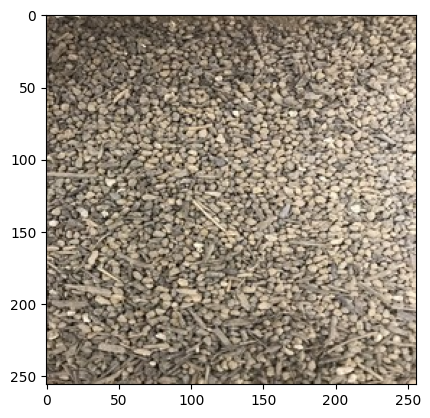

In [16]:
test_image_filepath = test_data_directory + r'/Sand/0.jpg'
print(make_prediction(test_image_filepath))

### **Класифікація ґрунтів у відсотках**

Ґрунти не є ідеально однорідними (повністю одного типу). Ґрунти часто є сумішшю типів і їх краще представити у відсотках. Наприклад, у клітинці нижче показано тестове фото з позначкою "Silt".

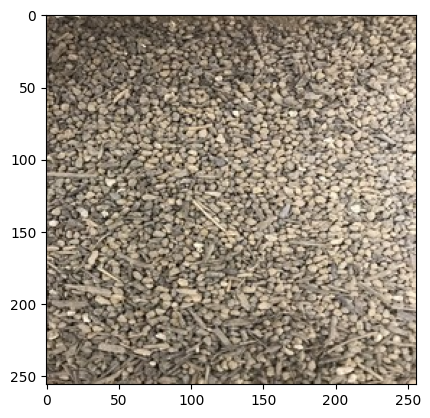

In [17]:
percentage_photo = test_data_directory + r"/Sand/0.jpg"
#percentage_photo = "/content/test_divided/Silt/10056img64_64.jpg"
im = cv2.imread(percentage_photo) # Завантаження зображення
plt.imshow(im[:,:,[2,1,0]]) # Вивід завантаженого зображення на екран

На цьому фото є трохи гравію, проте, схоже, що на одному фото є пісок, гравій та мул. Щоб краще класифікувати це зображення, створіть пропорцію для кожної мітки. Наприклад, це фото може бути 30% гравію, 20% піску та 50% мулу.

Розділіть фотографію на багато менших сегментів або квадратів та навчіть класифікатор на менших квадратах. Перейдіть по фотографії, щоб класифікувати кожен маленький квадрат та взяти пропорцію квадратів, що стосується гравію, піску та мулу. Ця пропорція потім перетворюється на відсоток відповідного типу ґрунту.

### **Дані**

Виконайте дії, наведені нижче, щоб **розділити існуючі навчальні фотографії на менші сегменти**. Новий каталог називатиметься `train_divided` та `test_divided`.

Для навчання моделі краще мати багато маленьких, різноманітних прикладів, ніж кілька великих і однотипних.

Нижче визначена функція працює як автоматичний **"різак для фотографій"**. Вона бере кожне велике зображення і нарізає його на безліч маленьких квадратних шматочків.

Результат полягає у тому, що з одного великого фото (розміром, скажімо, 1024x768) отримаємо сотні маленьких зображень (кожен розміром 64x64). Це значно збільшує наш набір даних для тренування, що робить модель розумнішою та стійкішою.

Ми визначаємо функцію split_images, яка приймає два аргументи:

* `image_dir` – шлях до папки, де лежать вихідні великі зображення, розсортовані за класами.
* `save_dir` – шлях до папки, куди ми будемо зберігати нарізані маленькі зображення.

Ця функція — це ефективний конвеєр, який автоматизує рутинну, але важливу роботу:
* Бере папку з великими фото.
* Проходить по кожному класу (Gravel, Sand, Silt).
* Бере кожне велике фото всередині класу.
* Нарізає його на сітку маленьких квадратиків 64x64.
* Зберігає кожен повноцінний квадратик у відповідну папку для оброблених даних.

In [18]:
def split_images(image_dir, save_dir):
    classification_list = ['Gravel', 'Sand', 'Silt']  # Створюємо список класів
    for classification in classification_list:  # Запускаємо цикл, який по черзі пройде по кожному елементу списку.
        # Спочатку classification буде "Gravel", потім "Sand", і так далі.
        # На кожному кроці циклу ми формуємо повні шляхи до папок
        folder = image_dir + '/' + classification + '/'   # Папка, звідки ми будемо брати великі зображення для поточного класу
        save_folder = save_dir + '/' + classification + '/' # Папка, куди ми будемо складати маленькі нарізані зображення для цього ж класу
        files = [f for f in listdir(folder) if isfile(join(folder, f))] # Отримуємо список усіх файлів, що знаходяться всередині поточної папки folder

        for file in files:  # Запускаємо ще один цикл, який пройде по кожному файлу з отриманого списку
            if '.ini' in file:  # Проста перевірка: якщо в назві файлу є .ini (це часто системні файли конфігурації), ми його ігноруємо і переходимо до наступного файлу
                continue
            fp = folder + file  # Створюємо повний шлях до конкретного файлу зображення
            img = cv2.imread(fp)  # Завантажуємо це велике зображення в пам'ять за допомогою бібліотеки cv2
            h,w,c = img.shape  # Дізнаємося розміри завантаженого зображення: h - висота, w - ширина, c - кількість каналів
            im_dim = 64 # Визначаємо розмір нашого "різака". Ми будемо нарізати зображення на квадратики 64x64 пікселі
            # For cropping images
            for r in range(0,img.shape[0],im_dim):  # Цей цикл іде по висоті зображення (по рядках, r - row) з кроком im_dim (64).
                                                    # Тобто r буде послідовно дорівнювати 0, 64, 128, 192, ...
                for c in range(0,img.shape[1],im_dim): # Цей цикл іде по ширині зображення (по колонках, c - column) з кроком 64. Тобто c буде 0, 64, 128, ...
                    # Разом ці цикли створюють координати лівого верхнього кута для кожного майбутнього маленького шматочка
                    cropped_img = img[r:r+im_dim, c:c+im_dim,:] # Ось і сама нарізка! Ми використовуємо індексацію NumPy, щоб "вирізати" шматок з великого зображення img
                                                                # r:r+im_dim: беремо пікселі по висоті від r до r+64.
                                                                # c:c+im_dim: беремо пікселі по ширині від c до c+64.
                                                                # :: беремо всі колірні канали.
                    ch, cw, cc = cropped_img.shape
                    if ch == im_dim and cw == im_dim:
                        # Коли наш "різак" доходить до правого або нижнього краю великого зображення, останній шматочок може виявитися меншим за 64x64.
                        # Ця перевірка гарантує, що ми зберігаємо тільки повноцінні квадрати 64x64.
                        write_path = f"{save_folder + str(randrange(100000))}img{r}_{c}.jpg"
                        cv2.imwrite(write_path,cropped_img) # Зберігаємо наш маленький нарізаний шматочок cropped_img на диск за створеним шляхом
                    else:
                        pass  # Якщо шматочок виявився неповним (меншим за 64x64), ми просто нічого не робимо і переходимо до наступного

Примітка:
За допомогою `write_path = ...` створюємо унікальний шлях для збереження файлу. Він складається з:
* `save_folder`: папки для цього класу.
* `str(randrange(100000))`: випадкового числа, щоб уникнути збігу імен.
* `img{r}_{c}.jpg`: координат r та c, з яких був вирізаний цей шматок. Це корисно для відстеження.

Наступний блок коду ставить на меті підготовку робочого простору перед тим, як запускати основну функцію нарізки зображень (`split_images`). Оскільки багато маленьких фотографій треба буде розкласти по папках, які треба спочатку створити та підписати. А вже потім робити нарізку.

Отже, код виконує такі операції:
1. **Створює нову структуру папок**: Він створює набір порожніх папок (`train_divided`, `test_divided`) з відповідними підпапками для кожного класу (Gravel, Sand, Silt).
  1. Обчислення батьківської директорії
  `parent = training_data_directory.replace('train', '')`
    * Береться шлях до тренувальної папки і замінюється підрядок "train" на порожній, фактично піднімаючись на рівень вище. Це зручно, щоб далі створити в тому ж корені папки train_divided та test_divided.
    * Метод `str.replace(old, new)` повертає новий рядок з підстановкою підрядка й не змінює оригінальний рядок.
  2. Списки нових директорій та класів
    * `dirs = ['train_divided', 'test_divided']` — цільові папки, куди буде покладено розділені зображення тренувального та тестового наборів.
    * `class_ = ["Gravel", "Sand", "Silt"]` — імена класів. Для кожної цільової директорії будуть створені підпапки з такими назвами.
  3. Створення структури папок
    * Зовнішній цикл `os.mkdir(os.path.join(parent, dir))` створює
        - `data/soil_images/train_divided` та
        - `data/soil_images/test_divided`.
    * Внутрішній цикл створює підпапки класів у кожній з цих директорій: наприклад,
        - `data/soil_images/train_divided/Gravel`,
        - `data/soil_images/train_divided/Sand`,
        - `data/soil_images/train_divided/Silt`
  і аналогічно для `test_divided`.
    * Якщо будь-яка з директорій уже існує, `os.mkdir` підніме `FileExistsError`. Це буде спіймано у блоці `except`, тому код не впаде.

```
/data/soil_images/
├── train/
│   ├── Gravel/ (тут лежать великі вихідні фото)
│   ...
├── test/
│   ├── Gravel/ (тут лежать великі вихідні фото)
│   ...
├── train_divided/  <-- Створено кодом
│   ├── Gravel/     <-- Створено кодом
│   ├── Sand/       <-- Створено кодом
│   └── Silt/       <-- Створено кодом
└── test_divided/   <-- Створено кодом
    ├── Gravel/     <-- Створено кодом
    ├── Sand/       <-- Створено кодом
    └── Silt/       <-- Створено кодом
```

2. **Запускає процес нарізки**: Після того, як папки готові, він викликає функцію `split_images`, щоб взяти великі зображення з вихідних папок і заповнити щойно створені папки маленькими нарізаними зображеннями.
  * `image_dir=training_data_directory`: брати великі зображення з папки `data/soil_images/train/`.
  * `save_dir=...`: зберігати маленькі нарізані зображення в папку `data/soil_images/train_divided/`. Знову використовується `.replace()`, щоб автоматично сформувати правильний шлях.
  * Робимо абсолютно те саме, але для тестових даних: брати великі зображення з `data/soil_images/test/` та зберігати маленькі нарізані зображення в `data/soil_images/test_divided/`.
3. **Має "захист від помилок"**: Він обгорнутий у конструкцію try...except, щоб не видавати помилку, якщо ви запускаєте скрипт вдруге і папки вже існують.
  * `try`:: Код намагається виконати все, що знаходиться всередині цього блоку.
except FileExistsError:: Якщо під час виконання try виникає конкретна помилка FileExistsError (яка трапляється, коли os.mkdir намагається створити папку, що вже існує), програма не "впаде" і не зупиниться. Замість цього вона перейде до блоку `except`.
  * `pass`: Це команда, яка означає "нічого не робити". Тобто, якщо папки вже існують, програма просто проігнорує помилку і спокійно продовжить роботу. Це робить скрипт зручним для повторного запуску.

In [19]:
try:
    parent = training_data_directory.replace('train', '')
    dirs = ['train_divided', 'test_divided']
    class_ = ["Gravel", "Sand", "Silt"]
    for dir in dirs:
        os.mkdir(os.path.join(parent, dir))
        for classification in class_:
            os.mkdir(os.path.join(parent, dir, classification))

    # Нарізати тренувальні зображення
    split_images(image_dir=training_data_directory,
                save_dir=training_data_directory.replace('train', 'train_divided'))
    # Нарізати тестові зображення
    split_images(image_dir=test_data_directory,
                save_dir=test_data_directory.replace('test', 'test_divided'))
except FileExistsError:
    pass

### **Завантажити модель**

Якщо кількість вхідних пікселів змінюється, слід навчити нову модель або масштабувати зображення до початкових навчальних розмірів. Для цілей цієї демонстрації повторне навчання не потрібне, оскільки фотографії масштабуються до 1024x1024 перед субдискретизацією 256x256 блоків (16) у кожному зображенні.

In [20]:
model_fp = os.getcwd()+'/'+'soil.h5'
print(model_fp)
model = load_model(model_fp)

/content/soil.h5


### **Класифікація зображень**

Використайте завантажену модель для класифікації тестового зображення. Функція `classify_images` бере зображення та модель і перебирає кожен квадрат розміром 256x256. Вона класифікує кожен квадрат і додає значення до лічильника, щоб створити дробовий прогноз ґрунту. Функція виводить частку кожного типу ґрунту, який було класифіковано.

---
**Більш детальний опис процедури класифікації**

1. Функція `classify_percentage('path/to/my_large_image.jpg')` запускає таймер і викликає `classify_images`.
2. Функція `classify_images` завантажує велике зображення, змінює його розмір до 1024x1024 і починає нарізати його на 16 шматочків (4x4) розміром 256x256.
Для кожного з 16 шматочків вона викликає `model_classify`.
3. Функція `model_classify` бере шматочок, готує його (масштабує, додає вимір) і отримує від моделі прогноз (наприклад, 'Gravel'). Цей прогноз повертається назад до `classify_images`.
4. Функція `classify_images` отримує 'Gravel' і збільшує лічильник gravel_count. Цей процес повторюється для всіх 16 шматочків.
5. Після аналізу всіх шматочків `classify_images` обчислює фінальні пропорції (наприклад, [0.25, 0.625, 0.125]) і повертає їх.
6. Функція `classify_percentage` отримує цей масив, зупиняє таймер, показує вихідне зображення і друкує фінальний звіт у відсотках.

---

Функція `model_classify` — наш "експерт", який вміє дивитися тільки на один маленький шматочок зображення (розміром 256x256) і казати, до якого класу він належить.

___Кроки___:

* *Підготовка*: Функція отримує на вхід один вирізаний шматочок cropped_img. Вона виконує ті самі кроки підготовки, що й під час тренування: масштабує пікселі (/ 255.) і додає фіктивний вимір "пакету" (np.expand_dims), бо модель predict очікує на вхід саме такий формат.
* *Прогноз*: Підготовлений шматочок передається моделі (model.predict). Модель повертає масив ймовірностей, наприклад [0.1, 0.2, 0.7].
* *Інтерпретація*: Метод np.argmax() знаходить індекс елемента з найвищою ймовірністю (у нашому прикладі це індекс 2). Потім цей індекс використовується для отримання назви класу зі списку classes (індекс 2 відповідає 'Silt').
* *Повернення результату*: Функція повертає назву класу у вигляді рядка (наприклад, 'Silt').

In [21]:
def model_classify(cropped_img, model):
    classes = ['Gravel', 'Sand', 'Silt'] # Словник для розшифровки
    image_array = cropped_img / 255   # Масштабуємо пікселі до діапазону [0, 1]
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0] #[0] щоб отримати результат для нашого єдиного зображення
    first_idx = np.argmax(prediction_array)   # Знаходимо індекс з найбільшою ймовірністю
    first_class = classes[first_idx]  # Перетворюємо індекс на назву класу
    print(prediction_array)
    return first_class

Функція `classify_images` — "керівник", який організовує роботу. Вона бере велике зображення, нарізає його на завдання (маленькі шматочки) і роздає їх "експерту" (model_classify). Потім вона збирає всі відповіді і підраховує підсумкову статистику.

In [22]:
def classify_images(image_fp, model):
    classes = ['Gravel', 'Sand', 'Silt']
    gravel_count = 0    # ініціалізація лічильників
    sand_count = 0
    silt_count = 0

    # Завантаження та нарізка великого зображення на шматочки
    img = cv2.imread(image_fp)
    img = cv2.resize(img,(1024,1024))
    im_dim = 256

    for r in range(0, img.shape[0], im_dim):
        for c in range(0, img.shape[1], im_dim):
            cropped_img = img[r:r + im_dim, c:c + im_dim, :]
            h, w, c = cropped_img.shape
            # Перевірка, що шматок повноцінний
            if h == im_dim and w == im_dim:
                # Відправити шматочок на аналіз "експерту"
                classification = model_classify(cropped_img, model)
                # Підрахунок "голосів"
                if classification == classes[0]:
                    gravel_count += 1
                elif classification == classes[1]:
                    sand_count += 1
                elif classification == classes[2]:
                    silt_count += 1
            else:
                continue
    # Розрахунок фінальних пропорцій
    print('---\n', 'Gravel: ', gravel_count, 'Sand: ', sand_count, 'Slit: ', silt_count)
    total_count = gravel_count + sand_count + silt_count
    proportion_array = [gravel_count / total_count, sand_count / total_count, silt_count / total_count]
    return proportion_array

Функція `classify_percentage` бере дані від `classify_images`, красиво їх оформлює, додає візуальний контекст (саме зображення) і представляє кінцевому користувачеві у зрозумілому вигляді.

In [23]:
def classify_percentage(image_fp):
    start = time.time()   # Запускаємо таймер
    out = classify_images(image_fp=image_fp, model=model)   # Запускаємо весь процес аналізу
    finish = str(round(time.time() - start, 5))   # Зупиняємо таймер

    im = cv2.imread(image_fp) # # Показуємо, що саме аналізували
    plt.imshow(im[:,:,[2, 1, 0]])

    # Друкуємо звіт
    print(f'''---
Percent Gravel: {round(out[0] * 100, 2)}%)
Percent Sand: {round(out[1] * 100, 2)}%)
Percent Silt: {round(out[2] * 100, 2)}%)
Time to Classify: {finish} seconds
---''')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
[0.7133175  0.08069583 0.20598671]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[0.7157452  0.06372937 0.22052544]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[0.6452865  0.05052679 0.30418676]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[0.5388591  0.02831377 0.43282714]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[0.69516265 0.04459155 0.26024577]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[0.6976294  0.0370199  0.26535076]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[0.6241521  0.02753545 0.3483124 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[0.3350818  0.01379307 0.65112513]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[0.6757018  0.0457616  0.27853662]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[0.70627993 0.04256658 0.25115347]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[0.5881671  0.03107259 0.3807604 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[0.35478234 0.01494657 0.6302711 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[0.6031833  0.05062249 0.34619412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[0.6187473  

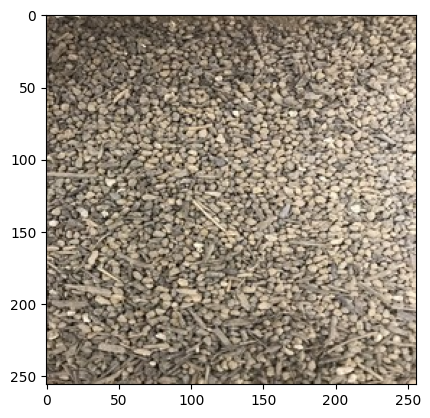

In [24]:
classify_percentage(image_fp=percentage_photo)

Чи відповідає відсоток класифікації фотографії?

Обидва підходи до класифікації ґрунту мають переваги. Наприклад, класифікація всього зображення є швидшою. Однак, відсоткова класифікація є більш обчислювально витратною, але надає більше інформації та може бути кращим відображенням справжньої класифікації.